In [55]:
import pandas as pd
import numpy as np
from numpy import inf
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [56]:
import os
os.chdir('/Users/KevinShao/Desktop/adsi_group2leftfeet')

In [57]:
test = pd.read_csv("data/raw/test.csv")
train = pd.read_csv("data/raw/train.csv")
target = train.pop("TARGET_5Yrs")

In [58]:
#changing negative values to 0 
train[train < 0] = 0
test[test < 0] = 0

In [59]:
df_train = train.iloc[:, 1:].values
df_test = test.iloc[:, 1:].values

In [60]:
#Upsmapling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=8)
training_set, target = sm.fit_sample(df_train, target)
print(target.value_counts(), np.bincount(target))

0    6669
1    6669
Name: TARGET_5Yrs, dtype: int64 [6669 6669]


In [61]:
#Splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split (training_set, target, test_size=0.2, random_state=8)

In [62]:
print(y_train.value_counts())

0    5363
1    5307
Name: TARGET_5Yrs, dtype: int64


In [64]:
#Normalizing the data as some might have % and other might have higher value such as GP and MIN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
test = scaler.fit_transform(test)

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

In [66]:
parameters = {
    "n_estimators":[500,1000],
    "max_depth":[5,7,9],
    "learning_rate":[0.01,0.1],
    "max_features":[11,15,19]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
gbm = GradientBoostingClassifier()
cv = GridSearchCV(gbm,parameters,cv=5)
cv.fit(X_train,y_train.values.ravel())

In [174]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [175]:
display(cv)

Best parameters are: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500}


0.622 + or -0.002 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.635 + or -0.004 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.662 + or -0.013 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}
0.677 + or -0.01 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}
0.65 + or -0.008 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.693 + or -0.014 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.784 + or -0.008 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.828 + or -0.006 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.705 + or -0.013 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.745 + or -0.017 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.828 + or -0.004 for the {'learning_rate': 0.01, 'max_dep

In [176]:
from joblib import dump
dump(cv,'models/gbm.joblib')

['models/gbm.joblib']

In [177]:
# make predictions for test data
y_pred_gbm = cv.predict(X_test)

In [178]:
print(classification_report(y_test, y_pred_gbm))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1306
           1       0.88      0.97      0.92      1362

    accuracy                           0.91      2668
   macro avg       0.92      0.91      0.91      2668
weighted avg       0.92      0.91      0.91      2668



In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_weight_bp, X_train, y_train, cmap=plt.cm.Blues, values_format='4d')  
plt.show()

In [179]:
from sklearn import metrics
print("roc_auc:",metrics.accuracy_score(y_test, y_pred_gbm))

roc_auc: 0.914167916041979


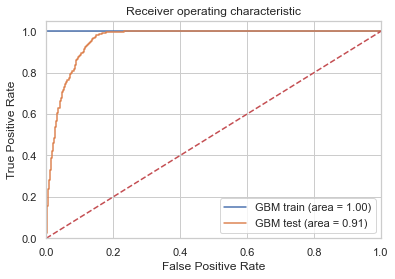

In [182]:
logit_roc_auc_test = roc_auc_score(y_test, gbm.predict(X_test))
logit_roc_auc_train = roc_auc_score(y_train, gbm.predict(X_train))
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, gbm.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr_train, tpr_train, label='GBM train (area = %0.2f)' % logit_roc_auc_train)
plt.plot(fpr_test, tpr_test, label='GBM test (area = %0.2f)' % logit_roc_auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [190]:
y_test_preds = gbm.predict_proba(test)[:,1]

ValueError: X has 20 features, but DecisionTreeRegressor is expecting 19 features as input.

In [186]:
print(test.shape)

(3799, 20)


In [ ]:
#printout prediction into a file
submission = pd.DataFrame({'Id':test['Id'],'TARGET_5Yrs':y_test_preds})
submission.to_csv('submission_week_3.csv',index=False)